In [3]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import datetime 
from datetime import date
from datetime import *; from dateutil.relativedelta import *
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.9f' % x)
np.set_printoptions(suppress=True)

In [4]:
import pydata_google_auth
credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-3425ks60hkk80fssi9vpohv88g6q1iqd.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=AGZIix7dQAnx6YhiNISVVe1b3hmJ9p&access_type=offline


In [5]:
client = bigquery.Client(project = 'etsy-bigquery-adhoc-prod', credentials=credentials)

In [15]:
sql = """
with fix_it as 
(select date, shop_id, max(coalesce(shop_gms,0)) as shop_gms ,
  max(coalesce(shop_visits,0)) as shop_visits,
  max(coalesce(shop_converted_visits,0)) as shop_converted_visits 
  from `etsy-data-warehouse-dev.tnormil.ytbc_shop_perf`
  group by 1,2)
select date, sum(coalesce(shop_gms,0)) as shop_gms ,
  sum(coalesce(shop_visits,0)) as shop_visits,
  sum(coalesce(shop_converted_visits,0)) as shop_converted_visits 
  from fix_it
  group by 1
"""

query_job = client.query(sql)
results = query_job.result()
ytbc_shop_perf = results.to_dataframe()

In [16]:
sql = """
select date, country, type, sum(coalesce(shop_gms,0)) as shop_gms ,
  sum(coalesce(shop_visits,0)) as shop_visits,
  sum(coalesce(shop_converted_visits,0)) as shop_converted_visits 
  from `etsy-data-warehouse-dev.tnormil.hl_shop_perf`
  group by 1,2,3
"""

query_job = client.query(sql)
results = query_job.result()
shop_perf = results.to_dataframe()

In [7]:
# sql = """
# SELECT date(timestamp_seconds(run_date)) as date, sum(visits) as visits
#     FROM `etsy-data-warehouse-prod.rollups.influencer_favorites_overview_toplevel` a
#     where slug_adjusted like 'etsyedit%'
#     group by 1;
# """

# query_job = client.query(sql)
# results = query_job.result()
# ytbc_ep = results.to_dataframe()

In [17]:
ytbc_shop_perf['date'] = pd.to_datetime(ytbc_shop_perf['date'])
shop_perf['date'] = pd.to_datetime(shop_perf['date'])
#ytbc_ep['date'] = pd.to_datetime(ytbc_ep['date'])

In [18]:
ytbc_shop_perf_new = ytbc_shop_perf.copy()
#ytbc_ep_new = ytbc_ep.copy()

shop_perf_new = shop_perf.loc[:,~shop_perf.columns.isin(['shop_converted_visits'])].copy()
shop_perf_new['key'] =  shop_perf_new['country'] + '_' + shop_perf_new['type']
shop_perf_new = shop_perf_new.pivot(index='date', columns='key', values=['shop_gms', 'shop_visits'])

shop_perf_new.columns = ['_'.join(col) for col in shop_perf_new.columns.values]

shop_perf_new = shop_perf_new.reset_index()

#shop_perf.melt(id_vars=["date", "join_key"], var_name="Date", value_name="Value")

In [19]:
ytbc_shop_perf_new = ytbc_shop_perf_new.set_index('date', drop=True)
ytbc_shop_perf_new = ytbc_shop_perf_new.sort_index()
    
for i in ytbc_shop_perf_new.columns:
        
    ytbc_shop_perf_new[i+'_ly'] = ytbc_shop_perf_new[i].shift(365)
        
#ytbc_ep_new = ytbc_ep_new.set_index('date', drop=True)
#ytbc_ep_new = ytbc_ep_new.sort_index()
    
#for i in ytbc_ep_new.columns:
        
#    ytbc_ep_new[i+'_ly'] = ytbc_ep_new[i].shift(365)
    
shop_perf_new = shop_perf_new.set_index('date', drop=True)
shop_perf_new = shop_perf_new.sort_index()
    
for i in shop_perf_new.columns:
        
    shop_perf_new[i+'_ly'] = shop_perf_new[i].shift(365)

In [20]:
ytbc_shop_perf_new.head()

,shop_gms,shop_visits,shop_converted_visits,shop_gms_ly,shop_visits_ly,shop_converted_visits_ly
date,,,,,,
2019-12-01,10429.136459400,5465,377,NaN,<NA>,<NA>
2019-12-02,9495.744819400,5210,362,NaN,<NA>,<NA>
2019-12-03,6570.574003000,4371,314,NaN,<NA>,<NA>
2019-12-04,3602.761962200,3819,201,NaN,<NA>,<NA>
2019-12-05,6327.313813800,3637,210,NaN,<NA>,<NA>


In [21]:
#ytbc_shop_perf_new['shop_visits']
#shop_perf_new['shop_gms_US_power seller']
model_base = pd.concat([ytbc_shop_perf_new['shop_visits'], ytbc_shop_perf_new['shop_visits_ly'],shop_perf_new], axis=1, join='outer', ignore_index=False)
model_base.fillna(0, inplace=True)
model_base = model_base.astype(int)

In [22]:
model_base[model_base.index >= '2022-01-01'].head()

,shop_visits,shop_visits_ly,shop_gms_GB_other,shop_gms_GB_power seller,shop_gms_GB_top seller,shop_gms_INTL_other,shop_gms_INTL_power seller,shop_gms_INTL_top seller,shop_gms_US_other,shop_gms_US_power seller,shop_gms_US_top seller,shop_visits_GB_other,shop_visits_GB_power seller,shop_visits_GB_top seller,shop_visits_INTL_other,shop_visits_INTL_power seller,shop_visits_INTL_top seller,shop_visits_US_other,shop_visits_US_power seller,shop_visits_US_top seller,shop_gms_GB_other_ly,shop_gms_GB_power seller_ly,shop_gms_GB_top seller_ly,shop_gms_INTL_other_ly,shop_gms_INTL_power seller_ly,shop_gms_INTL_top seller_ly,shop_gms_US_other_ly,shop_gms_US_power seller_ly,shop_gms_US_top seller_ly,shop_visits_GB_other_ly,shop_visits_GB_power seller_ly,shop_visits_GB_top seller_ly,shop_visits_INTL_other_ly,shop_visits_INTL_power seller_ly,shop_visits_INTL_top seller_ly,shop_visits_US_other_ly,shop_visits_US_power seller_ly,shop_visits_US_top seller_ly
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-01,16494,13456,173587,621614,464145,255521,1363756,777731,591909,2950134,1595798,440417,647559,769230,802833,1317093,1370313,1377661,2214882,2184674,342602,550530,398645,444672,923768,618734,1203187,2704226,1522591,615769,502148,565700,1090929,909020,956182,2150981,2090287,2016207
2022-01-02,21329,17133,227363,870102,617601,340777,1787282,994607,657113,3591048,1886781,539618,821673,940954,992915,1698983,1697326,1662430,2783555,2677452,410193,654110,500442,574418,1192508,770174,1412808,3282796,1878442,729884,600088,672050,1350643,1133961,1171710,2631864,2619955,2453904
2022-01-03,18740,17803,222239,911363,609936,330640,1770011,993583,625516,3514269,1772397,530476,800790,917618,906364,1554223,1528552,1487036,2475962,2371965,427715,696318,480916,572618,1265456,800037,1464818,3397405,1910443,760851,614533,688948,1388572,1180908,1223803,2740920,2730299,2569812
2022-01-04,16712,14834,204463,771422,563082,314672,1674886,948157,596965,3265695,1651959,472432,709319,826117,862401,1469536,1463587,1380854,2291928,2214247,385927,559268,434400,557246,1160314,750768,1331634,3121871,1759840,674258,513908,596153,1263941,1045712,1088618,2492797,2418400,2306618
2022-01-05,17024,14212,183984,747823,541712,324494,1629583,960927,592271,3145515,1639634,454492,697648,805103,844257,1454806,1443646,1361520,2290800,2211519,373362,586727,414409,508946,1105084,689517,1287120,2976851,1592199,670415,511361,595871,1178387,987118,1033289,2322077,2229411,2163483


In [23]:
from causalimpact import CausalImpact
import tensorflow as tf

In [24]:
pre_period = ['2022-01-01', '2022-05-29']
post_period = ['2022-05-30', '2022-10-31']
ci = CausalImpact(model_base, pre_period=pre_period, post_period=post_period)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python

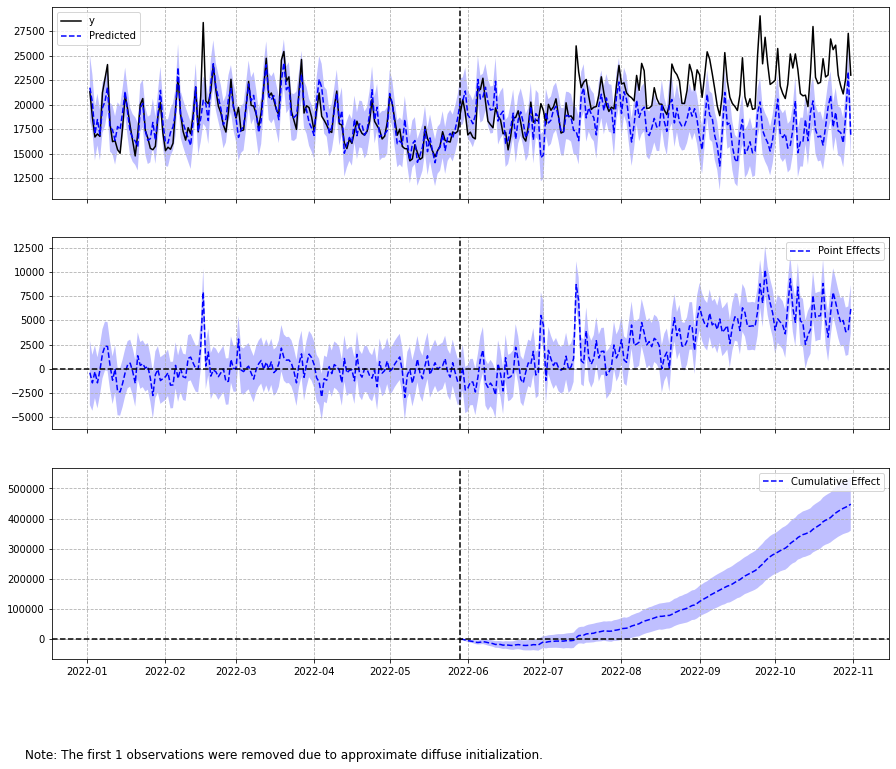

In [25]:
ci.plot()

In [26]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    21178.85           3282721.0
Prediction (s.d.)         18287.69 (296.94)  2834592.35 (46025.82)
95% CI                    [17693.1, 18857.09][2742431.19, 2922849.11]

Absolute effect (s.d.)    2891.15 (296.94)   448128.65 (46025.82)
95% CI                    [2321.75, 3485.74] [359871.89, 540289.81]

Relative effect (s.d.)    15.81% (1.62%)     15.81% (1.62%)
95% CI                    [12.7%, 19.06%]    [12.7%, 19.06%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [27]:
print(ci.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 21178.85. By contrast, in the absence of an
intervention, we would have expected an average response of 18287.69.
The 95% interval of this counterfactual prediction is [17693.1, 18857.09].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 2891.15 with a 95% interval of
[2321.75, 3485.74]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 3282721.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 2834592.35. The 95% interval of this prediction is [2742431.19, 2922849.11].


The above results are given in terms of absolute numbers. In rel